# Making a synthetic model

## import packages

In [2]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

import sys

sys.path.insert(1, "../")

# local python scripts
import RIS_gravity_inversion.inversion as inv
import RIS_gravity_inversion.plotting as plots
import RIS_gravity_inversion.utils as inv_utils
import RIS_gravity_inversion.synthetic as synth

from antarctic_plots import utils, regions, maps, fetch, profile
import zarr
import numpy as np
import pandas as pd
import xarray as xr
import verde as vd
import scipy as sp
import rioxarray
import pygmt

# for plotting
import pvxarray
import matplotlib.pyplot as plt
import optuna
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_slice
import holoviews as hv 
import hvplot.xarray
import hvplot.pandas
# hvplot.extension('bokeh', 'matplotlib', 'plotly')
import panel.widgets as pnw
import panel as pn
pn.extension(comms="vscode")

import os

PROJ: proj_create_from_database: Cannot find proj.db


# Set region and parameters

In [3]:
# set grid parameters
spacing = 1e3
registration="g"

inversion_region = [0e3, 80e3, 0e3, 60e3]

buffer_region = utils.alter_region(
    inversion_region,
    buffer=20e3,
    )[1]

outer_region = utils.alter_region(
    buffer_region,
    zoom=-spacing,
    )[0]

print("inversion region = ", inversion_region)
print("buffer region = ", buffer_region)
print("outer region = ", outer_region)

inversion region =  [0.0, 80000.0, 0.0, 60000.0]
buffer region =  [-20000, 100000, -20000, 80000]
outer region =  [-21000.0, 101000.0, -21000.0, 81000.0]


# Create synthetic layers

## Synthetic model
Here we'll construct a simple synthetic model

### flat upper layer

In [4]:
# create grid of coordinates
coords = vd.grid_coordinates(
    region=outer_region, 
    spacing=spacing,
    pixel_register=False,
    )

# create xarray dataarray from coordinates with a constant value of 0m
layer1 = vd.make_xarray_grid(
    coords, np.ones_like(coords[0]) * 0, data_names="z", dims=("y", "x")
).z

layer1 = fetch.resample_grid(
    layer1, spacing=spacing, region=buffer_region, registration=registration
)

utils.get_grid_info(layer1)

returning grid with new region and/or registration, same spacing


c:\Users\matthewt\AppData\Local\miniforge3\envs\RIS_gravity_inversion\lib\site-packages\xarray\backends\plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


(1000.0, [-20000.0, 100000.0, -20000.0, 80000.0], 0.0, 0.0, 'g')

### Layer2

returning grid with new region and/or registration, same spacing


(1000.0,
 [-20000.0, 100000.0, -20000.0, 80000.0],
 -850.314697266,
 -393.246643066,
 'g')

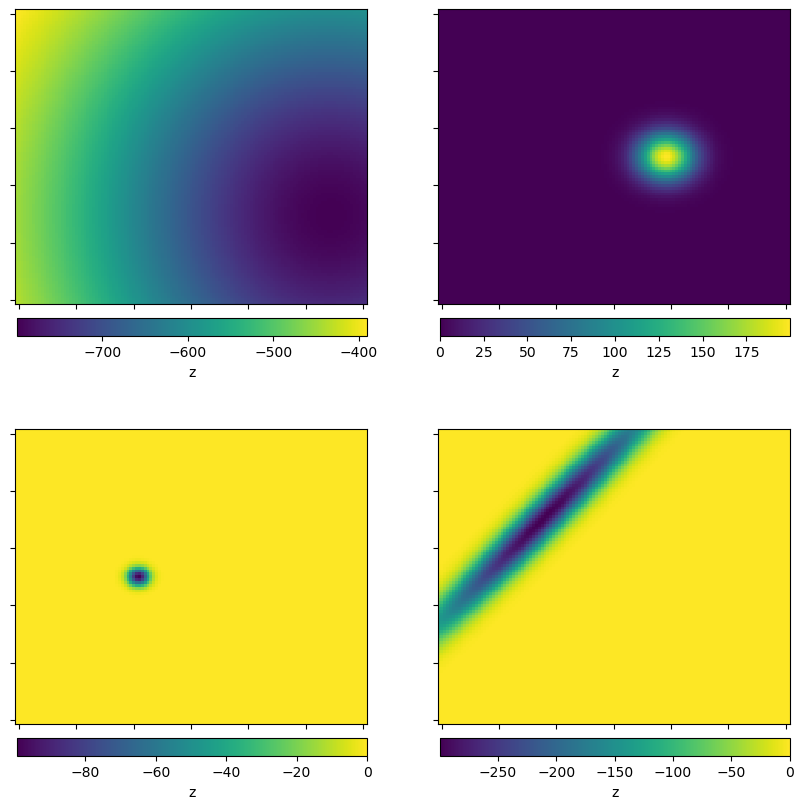

In [5]:
layer2 = synth.synthetic_topography_simple(
    spacing,
    outer_region,
    plot_individuals=True,
    registration=registration,
)

layer2 = fetch.resample_grid(
    layer2, spacing=spacing, region=buffer_region, registration=registration
)

utils.get_grid_info(layer2)

### base layer

returning grid with new region and/or registration, same spacing


(1000.0,
 [-20000.0, 100000.0, -20000.0, 80000.0],
 -4647.82373047,
 -3268.32446289,
 'g')

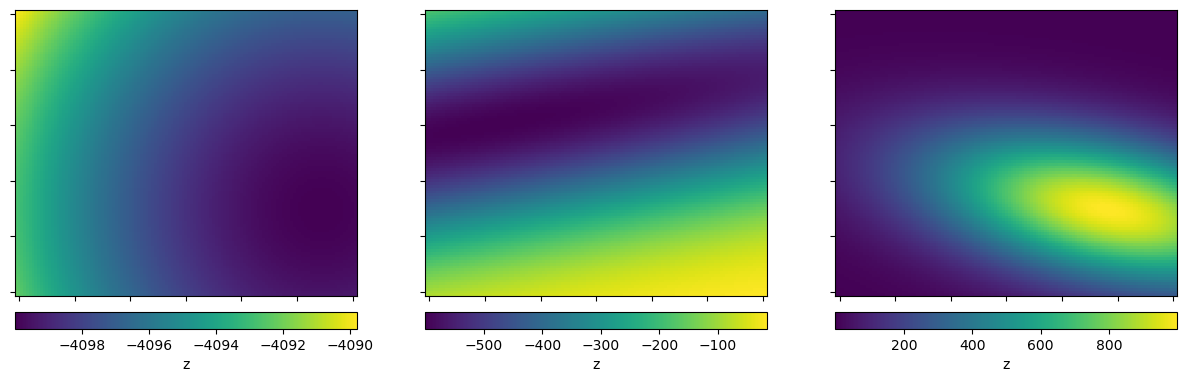

In [6]:
layer3 = synth.synthetic_topography_regional(
    spacing,
    outer_region,
    plot_individuals=True,
    registration=registration,
)

layer3 = fetch.resample_grid(
    layer3, spacing=spacing, region=buffer_region, registration=registration
)

utils.get_grid_info(layer3)

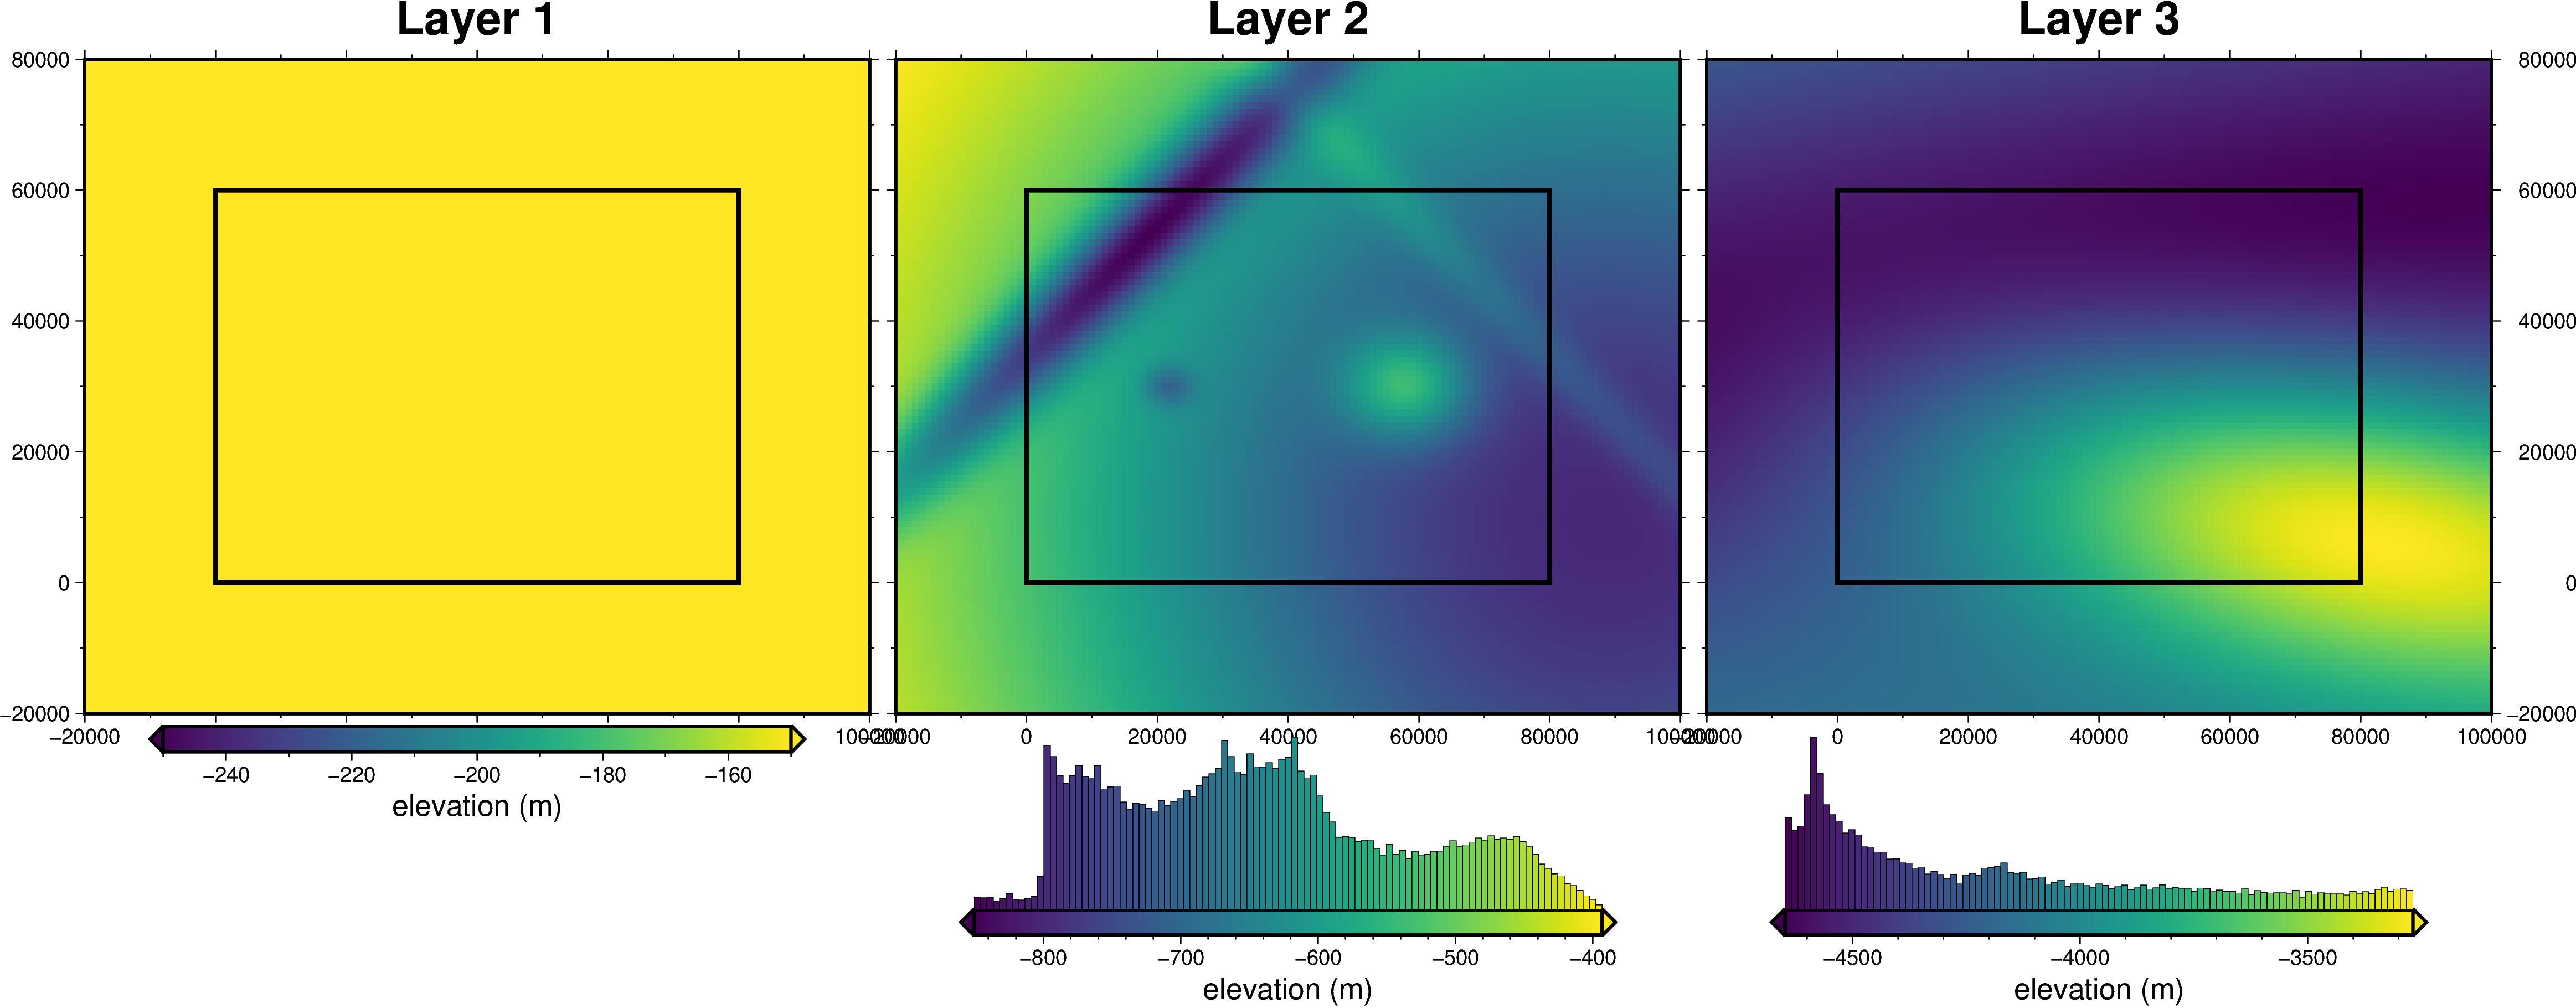

In [7]:
fig = maps.plot_grd(
    layer1,
    fig_height=10,
    title='Layer 1',
    cpt_lims=(-250, -150),
    cbar_label='elevation (m)',
    frame=["nSWe", "xaf10000", "yaf10000"],
    show_region=inversion_region,
    )

fig = maps.plot_grd(
    layer2,
    fig_height=10,
    title='Layer 2',
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
    cbar_label='elevation (m)',
    frame=["nSwe", "xaf10000", "yaf10000"],
    show_region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    )

fig = maps.plot_grd(
    layer3,
    fig_height=10,
    title='Layer 3',
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
    cbar_label='elevation (m)',
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
    fig=fig,
    origin_shift="xshift",
    )

fig.show()

### visualize in 3d

In [8]:
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

fig = make_subplots(
    rows=1, cols=2,
    specs=[[
        {'is_3d': True}, 
        {'is_3d': True}, 
        ]],
    subplot_titles=[
        'Layer 2',
        'Layer 3',
        ],
    )

fig.add_trace(go.Surface(z=layer2.values), 1, 1)
fig.add_trace(go.Surface(z=layer3.values), 1, 2)

fig.show()

### save to .zarr files

In [9]:
# save to zarr files
output = layer1.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/synthetic_layer1_simple.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

output = layer2.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/synthetic_layer2_simple.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

output = layer3.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/synthetic_layer3_simple.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)

### load .zarr files

In [10]:
layer1 = xr.open_zarr("../synthetic_data/synthetic_layer1_simple.zarr").z

layer2 = xr.open_zarr("../synthetic_data/synthetic_layer2_simple.zarr").z

layer3 = xr.open_zarr("../synthetic_data/synthetic_layer3_simple.zarr").z

## Observed gravity
use this synthetic model to create a synthethic gravity survey. This synthetic gravity anomaly will have both regional and short-wavelength signals, from the base layer and bathymetry layer, respectively.

### make a dictionary of properties

In [11]:
layers = {
    "layer1": {
        "spacing": spacing,
        "rho": 1030, #0, 
        "grid": layer1,
    },
    "layer2": {
        "spacing": spacing,
        "rho": 2300, #2300-1030,
        "grid": layer2,
    },
    "layer3": {
        "spacing": spacing,
        "rho": 2670, #2670-2300, 
        "grid": layer3,
    },
}

# resample layer grids to match
for k, v in layers.items():
    print(f"\n{'':*<20}Resampling {k} layer {'':*>20}")
    v["grid"] = fetch.resample_grid(
        v["grid"],
        spacing=v["spacing"],
        region=buffer_region,
        registration=registration,
        verbose="q",
    )
    print(utils.get_grid_info(v["grid"]))


********************Resampling layer1 layer ********************
returning original grid
(1000.0, [-20000.0, 100000.0, -20000.0, 80000.0], 0.0, 0.0, 'g')

********************Resampling layer2 layer ********************
returning original grid
(1000.0, [-20000.0, 100000.0, -20000.0, 80000.0], -850.314697266, -393.246643066, 'g')

********************Resampling layer3 layer ********************
returning original grid
(1000.0, [-20000.0, 100000.0, -20000.0, 80000.0], -4647.82373047, -3268.32446289, 'g')


### forward gravity of the model

#### make a prism model

********** layer3 top: -4194m and bottom: -4647m **********
********** layer2 top: -642m and bottom: -4194m **********

********** layer1 top: 0m and bottom: -642m **********



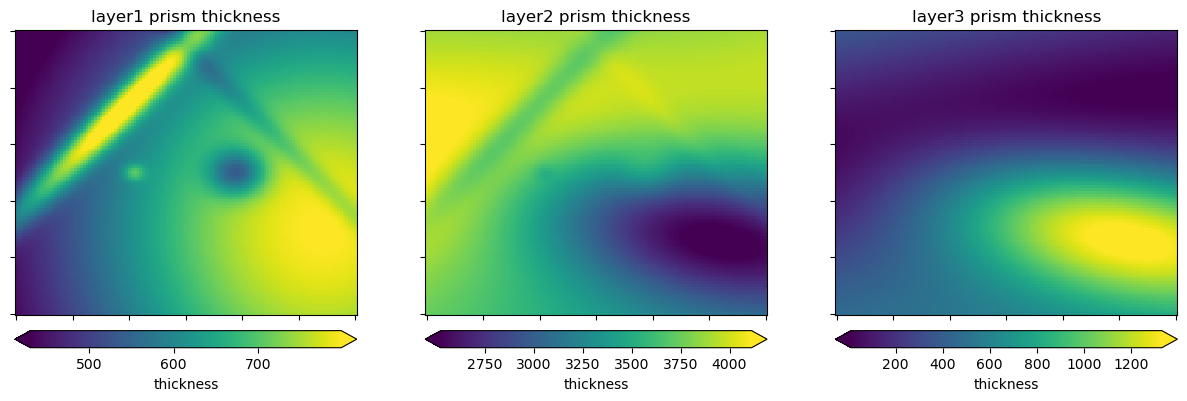

In [12]:
inv.grids_to_prism_layers(
    layers,
    registration="g",
)

plots.plot_prism_layers(
    layers,
    # plot_type='3D',
    # color_by='density',
    color_by='thickness',
    clip_box=False,
    log_scale=False,
    layers_for_3d=['layer2', 'layer3'],
    zscale=10,
)

### Forward gravity of full region

make pandas dataframe of locations to calculate gravity

In [13]:
synthetic_grav_spacing = spacing
# synthetic_grav_spacing = 10e3
# create lists of coordinates
(x, y) = vd.grid_coordinates(
    region=buffer_region, 
    spacing=synthetic_grav_spacing, 
    pixel_register=False,
    )

# grid the coordinates with a constant height of 1km
observations = vd.make_xarray_grid(
    (x, y),
    np.ones_like(x) * 1e3,
    data_names="z",
    dims=("y", "x"),
).z

# observations = fetch.resample_grid(observations, region=inversion_region, registration=registration)
print(utils.get_grid_info(observations))

df = vd.grid_to_table(observations)

(1000.0, [-20000.0, 100000.0, -20000.0, 80000.0], 1000.0, 1000.0, 'g')


#### calculate forward gravity of model

In [14]:
synthetic_forward = inv.forward_grav_layers(
    layers,
    df,
    exclude_layers=None,
    progressbar=True,
    parallel=True,
)

  0%|          | 0/12221 [00:00<?, ?it/s]

12221 prisms in layer1 layer
finished layer1 layer


  0%|          | 0/12221 [00:00<?, ?it/s]

12221 prisms in layer2 layer
finished layer2 layer


  0%|          | 0/12221 [00:00<?, ?it/s]

12221 prisms in layer3 layer
finished layer3 layer


#### plot the results

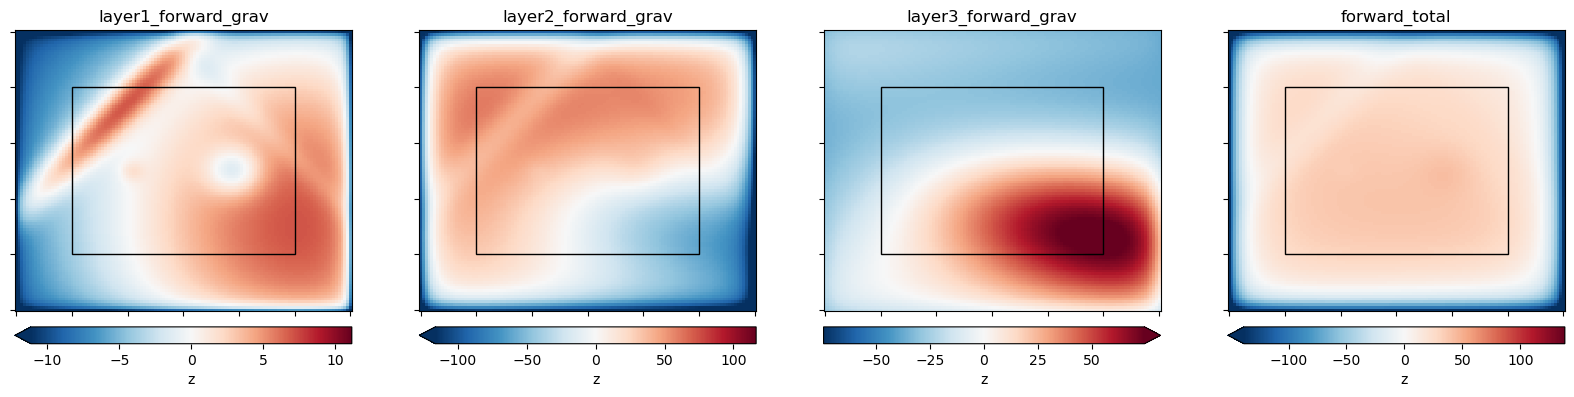

In [15]:
# with buffer region
forward_grids = plots.forward_grav_plotting(
    synthetic_forward,
    region=buffer_region,
    grav_spacing=synthetic_grav_spacing,
    inversion_region=inversion_region,
)

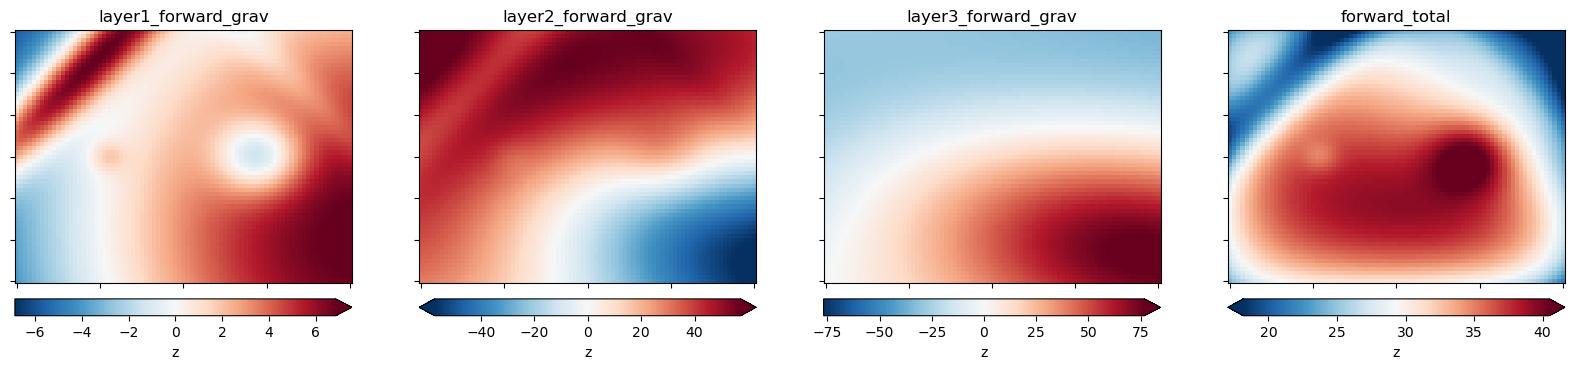

In [16]:
# just inversion region
forward_grids = plots.forward_grav_plotting(
    synthetic_forward,
    region=inversion_region,
    grav_spacing=synthetic_grav_spacing,
)

### Forward gravity of just inversion area

make pandas dataframe of locations to calculate gravity

In [17]:
synthetic_grav_spacing = spacing
# synthetic_grav_spacing = 10e3
# create lists of coordinates
(x, y) = vd.grid_coordinates(
    region=inversion_region, 
    spacing=synthetic_grav_spacing, 
    pixel_register=False,
    )

# grid the coordinates with a constant height of 1km
observations = vd.make_xarray_grid(
    (x, y),
    np.ones_like(x) * 1e3,
    data_names="z",
    dims=("y", "x"),
).z

# observations = fetch.resample_grid(observations, region=inversion_region, registration=registration)
print(utils.get_grid_info(observations))

df = vd.grid_to_table(observations)

(1000.0, [0.0, 80000.0, 0.0, 60000.0], 1000.0, 1000.0, 'g')


#### calculate forward gravity of model

In [18]:
synthetic_forward = inv.forward_grav_layers(
    layers,
    df,
    exclude_layers=None,
    progressbar=True,
    parallel=True,
)

  0%|          | 0/4941 [00:00<?, ?it/s]

12221 prisms in layer1 layer
finished layer1 layer


  0%|          | 0/4941 [00:00<?, ?it/s]

12221 prisms in layer2 layer
finished layer2 layer


  0%|          | 0/4941 [00:00<?, ?it/s]

12221 prisms in layer3 layer
finished layer3 layer


#### plot the results

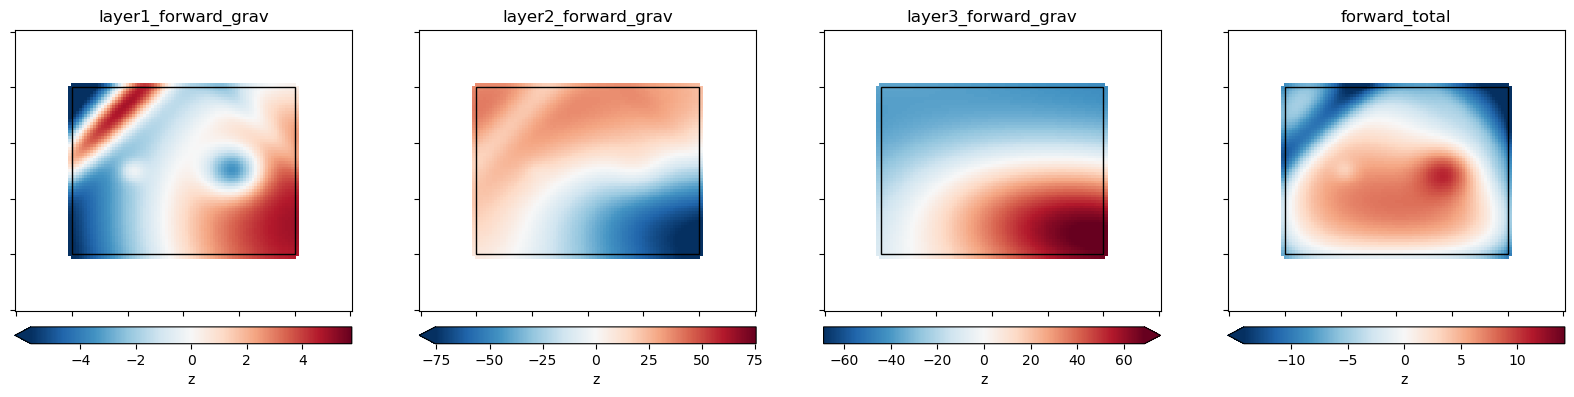

In [19]:
# with buffer region
forward_grids = plots.forward_grav_plotting(
    synthetic_forward,
    region=buffer_region,
    grav_spacing=synthetic_grav_spacing,
    inversion_region=inversion_region,
)

In [20]:
pd.options.plotting.backend = 'holoviews'
# synthetic_forward.drop(['x','y','z'], axis=1).plot(kind='hist', alpha=0.5, bins=50)
synthetic_forward.drop(['x','y','z'], axis=1).plot(kind='hist', subplots=True, width=300, bins=50).cols(2)

:NdLayout   [Default]
   :Histogram   [forward_total]   (forward_total_count)

In [21]:
# rename dataarray variables
for k,v in forward_grids.items():
    forward_grids[k]=v.rename(k)

# combine into a dataset
forward_grav = xr.merge(list(forward_grids.values()))

# save to a .zarr file
forward_grav.to_zarr(
    "../synthetic_data/synthetic_forward_grav_simple.zarr",
    mode="w",
)

# load zarr file
forward_grav = xr.open_zarr("../synthetic_data/synthetic_forward_grav_simple.zarr")
forward_grav

<xarray.Dataset>
Dimensions:              (y: 101, x: 121)
Coordinates:
  * x                    (x) float64 -2e+04 -1.9e+04 -1.8e+04 ... 9.9e+04 1e+05
  * y                    (y) float64 -2e+04 -1.9e+04 -1.8e+04 ... 7.9e+04 8e+04
Data variables:
    forward_total        (y, x) float32 dask.array<chunksize=(101, 121), meta=np.ndarray>
    layer1_forward_grav  (y, x) float32 dask.array<chunksize=(101, 121), meta=np.ndarray>
    layer2_forward_grav  (y, x) float32 dask.array<chunksize=(101, 121), meta=np.ndarray>
    layer3_forward_grav  (y, x) float32 dask.array<chunksize=(101, 121), meta=np.ndarray>
Attributes:
    actual_range:  [-8.032878875732422, 4.90045166015625]
    long_name:     z

### add noise

In [22]:
synthetic_forward["grav_noisy"] = synth.contaminate(
    synthetic_forward.forward_total,
    stddev=0.02,
    percent=True,
    seed=0,
)
synthetic_forward.describe()

y             x       z  layer1_forward_grav  \
count   4941.000000   4941.000000  4941.0         4.941000e+03   
mean   30000.000000  40000.000000  1000.0        -9.203549e-17   
std    17608.598838  23383.270257     0.0         2.612268e+00   
min        0.000000      0.000000  1000.0        -7.849119e+00   
25%    15000.000000  20000.000000  1000.0        -1.582496e+00   
50%    30000.000000  40000.000000  1000.0        -6.970496e-02   
75%    45000.000000  60000.000000  1000.0         1.812739e+00   
max    60000.000000  80000.000000  1000.0         4.896079e+00   

       layer2_forward_grav  layer3_forward_grav  forward_total    grav_noisy  
count         4.941000e+03         4.941000e+03   4.941000e+03  4.941000e+03  
mean         -1.472568e-14         4.417703e-15  -8.467265e-15 -8.099123e-15  
std           3.188772e+01         3.351261e+01   6.084993e+00  6.092305e+00  
min          -8.250307e+01        -4.293842e+01  -1.981708e+01 -1.999109e+01  
25%          -2.024240e+01        -3.132436e+01  -4.474139e+00 -4.485176e+00  
50%           1.092608e+01        -6.768858e+00   1.017343e+00  9.950660e-01  
75%           2.482512e+01         2.531521e+01   5.023350e+00  5.048642e+00  
max           3.930193e+01         7.180947e+01   1.090613e+01  1.149103e+01

compare with and without noise

returning original grid
returning original grid


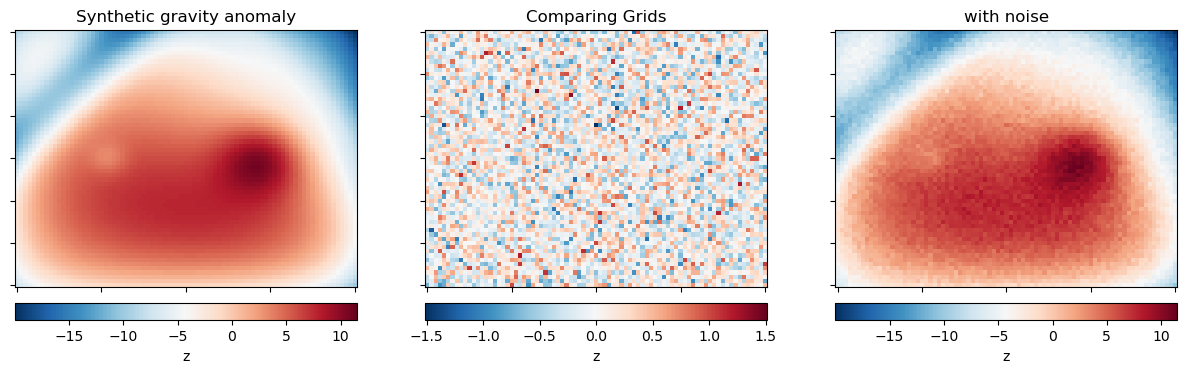

In [23]:
grav_noise_free = synthetic_forward.set_index(["y", "x"]).to_xarray().forward_total
grav_noisy = synthetic_forward.set_index(["y", "x"]).to_xarray().grav_noisy

grids = utils.grd_compare(
    grav_noise_free,
    grav_noisy,
    plot=True,
    region=inversion_region,
    plot_type='xarray',
    cmap="RdBu_r",
    grid1_name="Synthetic gravity anomaly",
    grid2_name="with noise",
    )

### create observation points

In [32]:
obs_grav_spacing = 2e3

# regular grid 
coords = vd.grid_coordinates(
    region=inversion_region, 
    spacing=obs_grav_spacing,
    pixel_register=False,
    )

# turn coordinates into dataarray
grav = vd.make_xarray_grid(
    coords, data=np.ones_like(coords[0]) * 1e3, data_names="z", dims=("y", "x")
)
# turn dataarray into dataframe
df = vd.grid_to_table(grav)
df

# # irregular grid
# simulate N-S tie lines
# x = np.arange(inversion_region[0], inversion_region[1], 50e3)
# y = np.arange(inversion_region[2], inversion_region[3], obs_grav_spacing)
# coords = np.meshgrid(x, y)
# # turn coordinates into dataarray
# ties = vd.make_xarray_grid(
#     coords, data=np.ones_like(coords[0]) * 1e3, data_names="z", dims=("y", "x")
# )
# # turn dataarray into dataframe
# df_ties = vd.grid_to_table(ties)

# # simulate E-W flight lines
# x = np.arange(inversion_region[0], inversion_region[1], obs_grav_spacing)
# y = np.arange(inversion_region[2], inversion_region[3], 15e3)
# coords = np.meshgrid(x, y)
# # turn coordinates into dataarray
# lines = vd.make_xarray_grid(
#     coords, data=np.ones_like(coords[0]) * 1e3, data_names="z", dims=("y", "x")
# )
# # turn dataarray into dataframe
# df_lines = vd.grid_to_table(lines)

# # merge dataframes
# df = pd.concat([df_ties, df_lines])
# df

y        x       z
0         0.0      0.0  1000.0
1         0.0   2000.0  1000.0
2         0.0   4000.0  1000.0
3         0.0   6000.0  1000.0
4         0.0   8000.0  1000.0
...       ...      ...     ...
1266  60000.0  72000.0  1000.0
1267  60000.0  74000.0  1000.0
1268  60000.0  76000.0  1000.0
1269  60000.0  78000.0  1000.0
1270  60000.0  80000.0  1000.0

[1271 rows x 3 columns]

### sample grid

In [33]:
# grid the synthetic gravity data
synthetic_gravity = synthetic_forward.set_index(["y", "x"]).to_xarray().grav_noisy

# sample the noisy data at the observation points
grav = profile.sample_grids(df, synthetic_gravity, "Gobs")
grav

y        x       z       Gobs
0         0.0      0.0  1000.0  -6.584907
1         0.0   2000.0  1000.0  -5.519683
2         0.0   4000.0  1000.0  -4.078683
3         0.0   6000.0  1000.0  -3.573910
4         0.0   8000.0  1000.0  -3.294372
...       ...      ...     ...        ...
1266  60000.0  72000.0  1000.0 -14.358978
1267  60000.0  74000.0  1000.0 -16.021515
1268  60000.0  76000.0  1000.0 -16.902208
1269  60000.0  78000.0  1000.0 -18.532539
1270  60000.0  80000.0  1000.0 -19.991091

[1271 rows x 4 columns]

grid the sampled points

In [34]:
Gobs = pygmt.surface(
    data=grav[["x", "y", "Gobs"]],
    region=inversion_region,
    spacing=obs_grav_spacing,
    registration=registration,
    T=0.25,
    verbose="q",
)

plot synthetic gravity anomaly

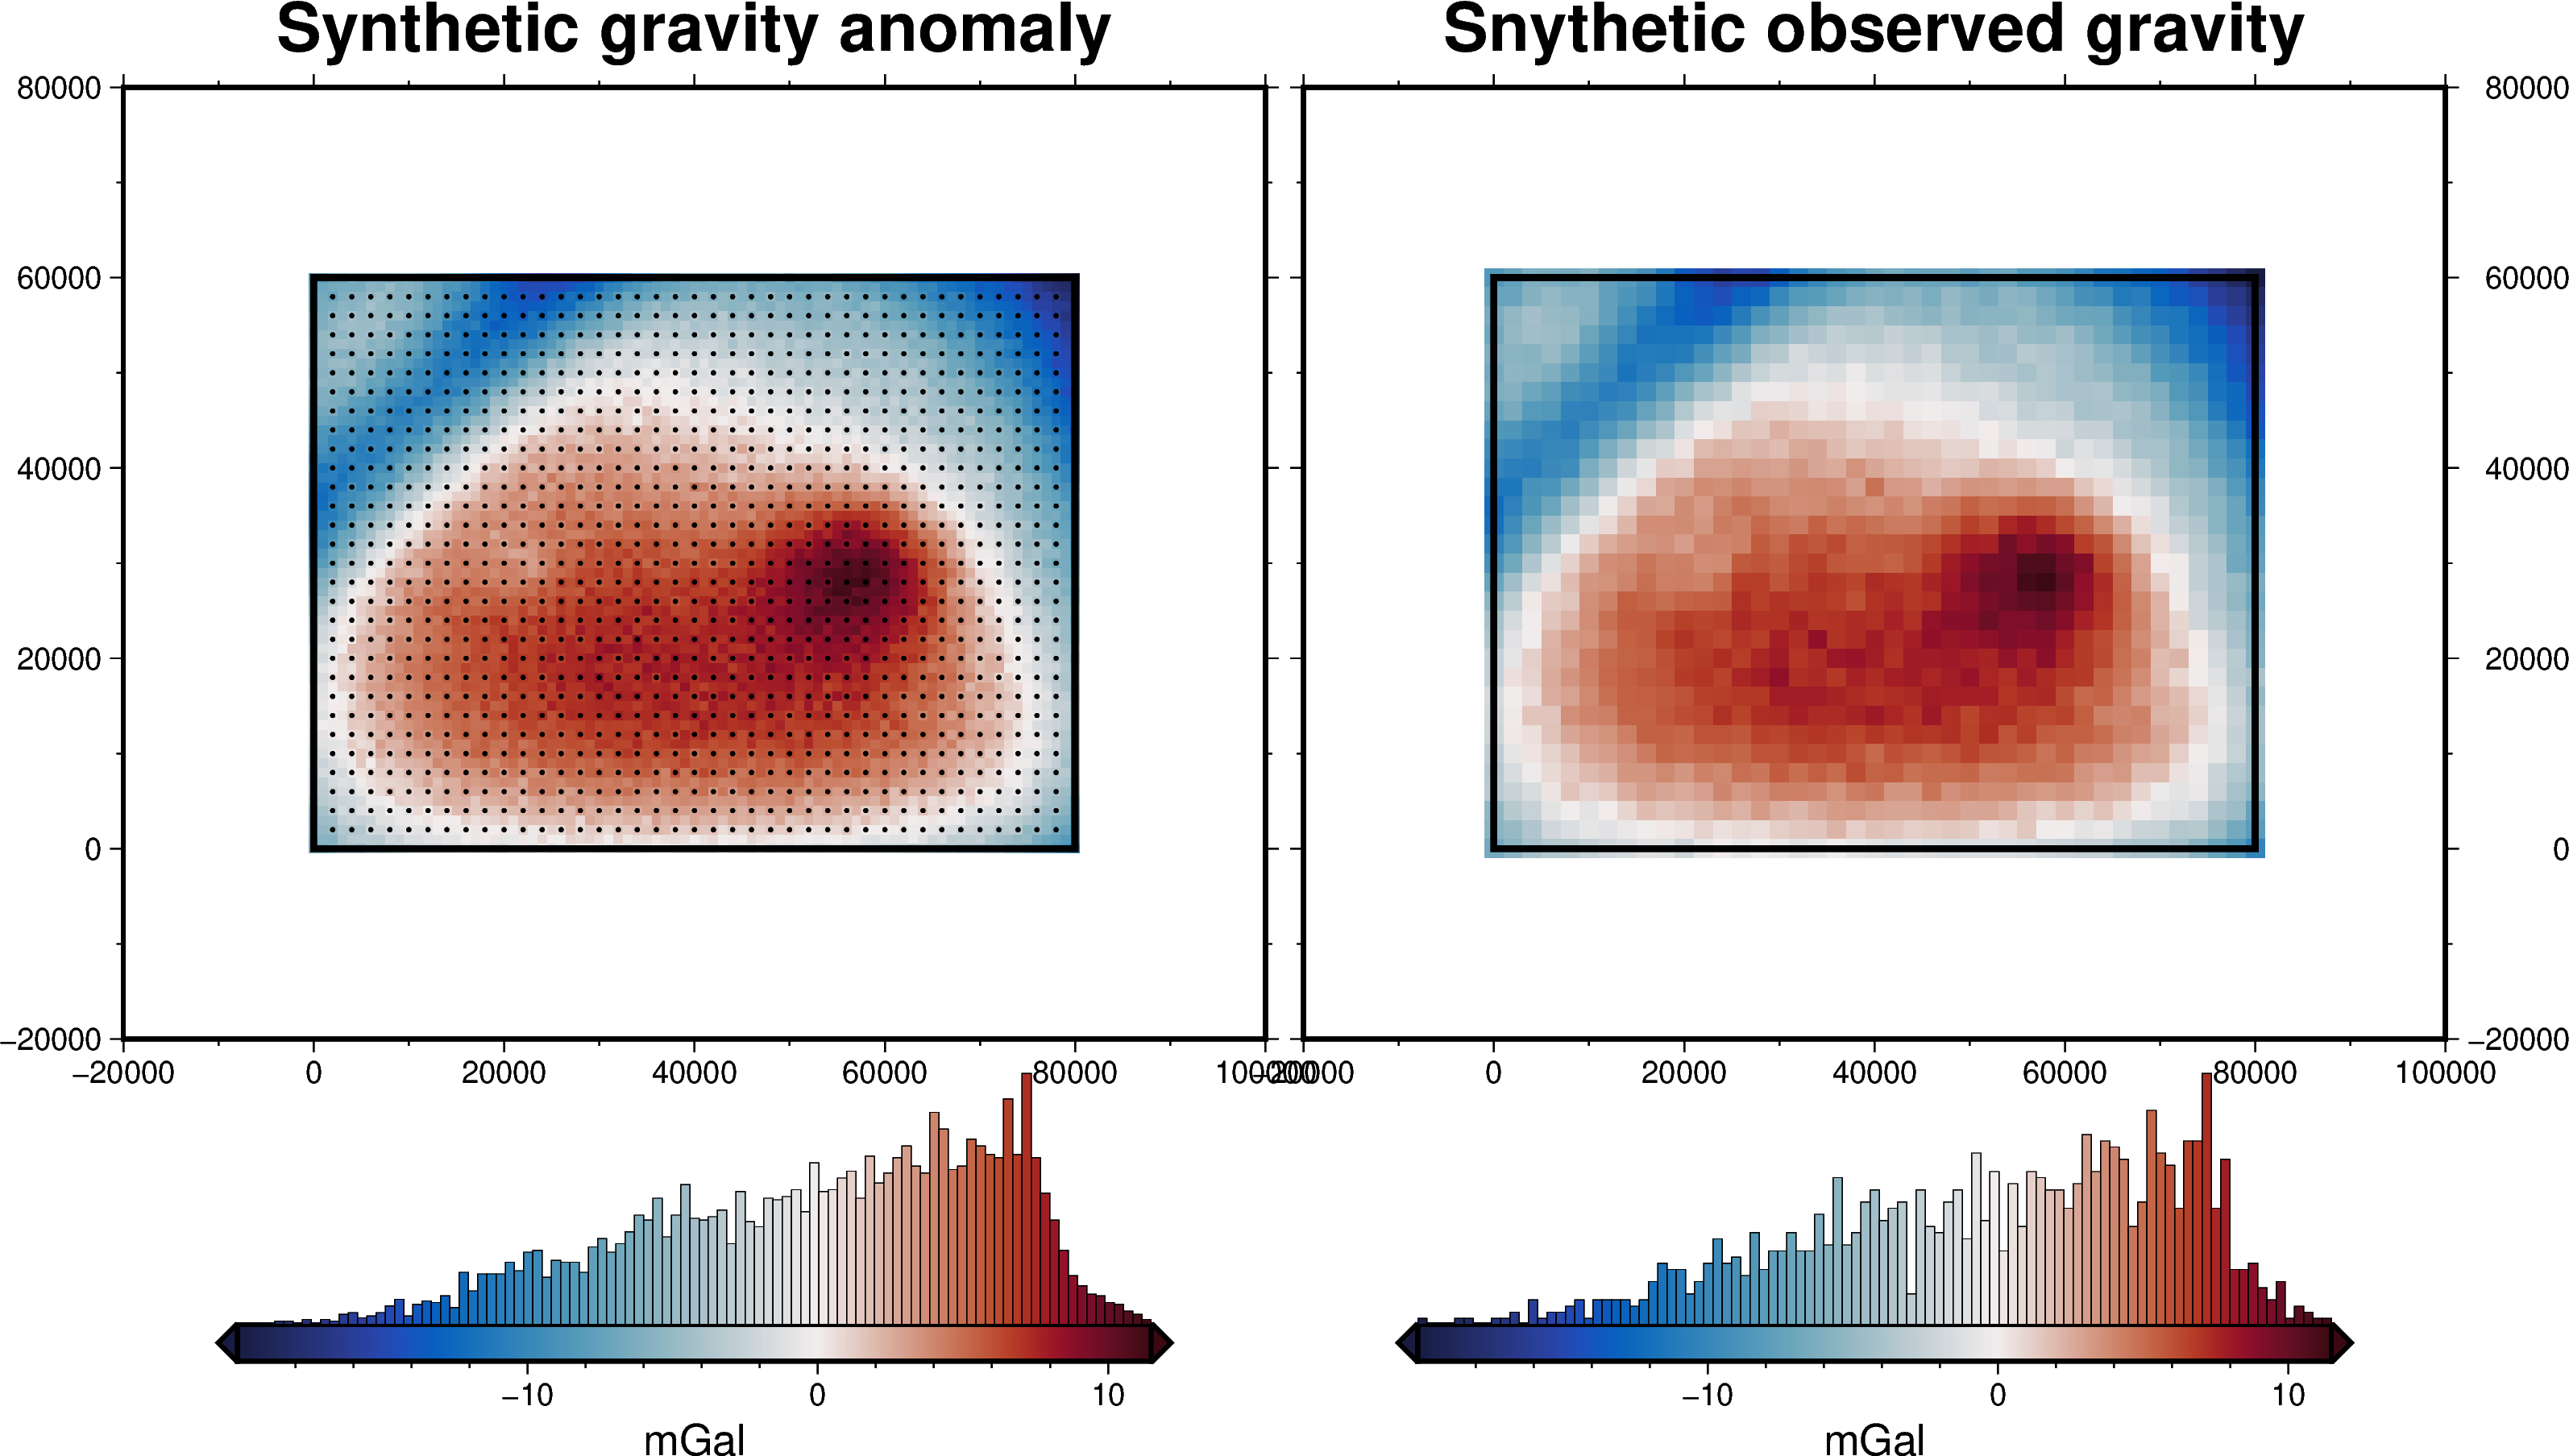

In [35]:
# plot the synthetic gravity anomaly grid
fig = maps.plot_grd(
    synthetic_gravity,
    region=buffer_region,
    fig_height=10,
    cmap="balance+h0",
    title='Synthetic gravity anomaly',
    cbar_label='mGal',
    frame=["nSWe", "xaf10000", "yaf10000"],
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
    )

# plot observation points
fig.plot(grav[['x','y']], style="c.05c", color="black")

# plot the synthetic observed gravity grid
fig = maps.plot_grd(
    Gobs,
    region=buffer_region,
    fig_height=10,
    cmap="balance+h0",
    title='Synthetic observed gravity',
    cbar_label='mGal',
    frame=["nSwE", "xaf10000", "yaf10000"],
    show_region=inversion_region,
    hist=True,
    cbar_yoffset=3,
    grd2_cpt=True,
    fig=fig,
    origin_shift='xshift',
    )

fig.show()

## save to a csv
re-format the dataframe

In [36]:
grav.rename(
    columns={
        "z": "ellipsoidal_elevation",
        "Gobs": "free_air_anomaly",
    },
    inplace=True,
)
grav

y        x  ellipsoidal_elevation  free_air_anomaly
0         0.0      0.0                 1000.0         -6.584907
1         0.0   2000.0                 1000.0         -5.519683
2         0.0   4000.0                 1000.0         -4.078683
3         0.0   6000.0                 1000.0         -3.573910
4         0.0   8000.0                 1000.0         -3.294372
...       ...      ...                    ...               ...
1266  60000.0  72000.0                 1000.0        -14.358978
1267  60000.0  74000.0                 1000.0        -16.021515
1268  60000.0  76000.0                 1000.0        -16.902208
1269  60000.0  78000.0                 1000.0        -18.532539
1270  60000.0  80000.0                 1000.0        -19.991091

[1271 rows x 4 columns]

In [37]:
grav["lat"] = np.nan
grav["lon"] = np.nan
grav["station_ID"] = np.nan
grav["geoidal_elevation"] = np.nan
grav["elevation_error"] = np.nan
grav["observed_gravity"] = np.nan
grav["observed_gravity_error"] = np.nan
grav["gravity_disturbance"] = np.nan
grav["gravity_disturbance_error"] = np.nan
grav["free_air_anomaly_error"] = np.nan

In [38]:
grav = grav[
    [
        "x",
        "y",
        "lat",
        "lon",
        "station_ID",
        "ellipsoidal_elevation",
        "geoidal_elevation",
        "elevation_error",
        "observed_gravity",
        "observed_gravity_error",
        "gravity_disturbance",
        "gravity_disturbance_error",
        "free_air_anomaly",
        "free_air_anomaly_error",
    ]
]
grav

x        y  lat  lon  station_ID  ellipsoidal_elevation  \
0         0.0      0.0  NaN  NaN         NaN                 1000.0   
1      2000.0      0.0  NaN  NaN         NaN                 1000.0   
2      4000.0      0.0  NaN  NaN         NaN                 1000.0   
3      6000.0      0.0  NaN  NaN         NaN                 1000.0   
4      8000.0      0.0  NaN  NaN         NaN                 1000.0   
...       ...      ...  ...  ...         ...                    ...   
1266  72000.0  60000.0  NaN  NaN         NaN                 1000.0   
1267  74000.0  60000.0  NaN  NaN         NaN                 1000.0   
1268  76000.0  60000.0  NaN  NaN         NaN                 1000.0   
1269  78000.0  60000.0  NaN  NaN         NaN                 1000.0   
1270  80000.0  60000.0  NaN  NaN         NaN                 1000.0   

      geoidal_elevation  elevation_error  observed_gravity  \
0                   NaN              NaN               NaN   
1                   NaN              NaN               NaN   
2                   NaN              NaN               NaN   
3                   NaN              NaN               NaN   
4                   NaN              NaN               NaN   
...                 ...              ...               ...   
1266                NaN              NaN               NaN   
1267                NaN              NaN               NaN   
1268                NaN              NaN               NaN   
1269                NaN              NaN               NaN   
1270                NaN              NaN               NaN   

      observed_gravity_error  gravity_disturbance  gravity_disturbance_error  \
0                        NaN                  NaN                        NaN   
1                        NaN                  NaN                        NaN   
2                        NaN                  NaN                        NaN   
3                        NaN                  NaN                        NaN   
4                        NaN                  NaN                        NaN   
...                      ...                  ...                        ...   
1266                     NaN                  NaN                        NaN   
1267                     NaN                  NaN                        NaN   
1268                     NaN                  NaN                        NaN   
1269                     NaN                  NaN                        NaN   
1270                     NaN                  NaN                        NaN   

      free_air_anomaly  free_air_anomaly_error  
0            -6.584907                     NaN  
1            -5.519683                     NaN  
2            -4.078683                     NaN  
3            -3.573910                     NaN  
4            -3.294372                     NaN  
...                ...                     ...  
1266        -14.358978                     NaN  
1267        -16.021515                     NaN  
1268        -16.902208                     NaN  
1269        -18.532539                     NaN  
1270        -19.991091                     NaN  

[1271 rows x 14 columns]

In [39]:
grav.to_csv(
    "../synthetic_data/synthetic_gravity_simple.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

## create random constraint points

In [40]:
coords = vd.scatter_points(region=inversion_region, size=33, random_state=1)
constraint_points = pd.DataFrame(data={"x": coords[0], "y": coords[1]})

In [41]:
constraint_points.to_csv(
    "../synthetic_data/synthetic_constraints_simple.csv.gz",
    sep=",",
    na_rep="",
    header=True,
    index=False,
    encoding="utf-8",
    compression="gzip",
)

## create starting Layer2

grid spacings don't match, using smaller spacing (1000.0m).
returning original grid
Warning, requested spacing (1000.0) is smaller than the original  (2000.0).


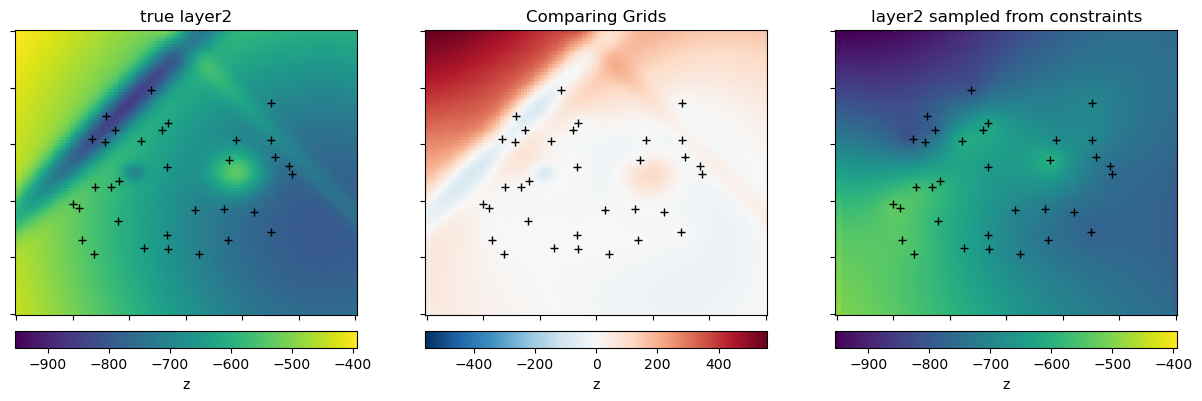

In [43]:
df = constraint_points.copy()
df = profile.sample_grids(df, layer2, "z")
starting_layer2 = pygmt.surface(
    data=df,
    region=buffer_region,
    spacing=obs_grav_spacing,
    registration=registration,
    T=0.35,
    verbose="q",
)

# compare starting and actual layer2 grids
grids = utils.grd_compare(
    layer2,
    starting_layer2,
    plot=True,
    plot_type='xarray',
    grid1_name="true layer2",
    grid2_name="layer2 sampled from constraints",
    points=df,
    show_region=inversion_region,
    )

## save inputs as .zarr files

In [44]:
output = starting_layer2.to_dataset(name="z")
output.to_zarr(
    "../synthetic_data/synthetic_starting_layer2_simple.zarr",
    encoding={"z": {"compressor": zarr.Blosc()}},
    mode="w",
)